In [1]:
# from numba import jit
# from tqdm import trange
# import pandas as pd
# eo_df = pd.read_csv("/mnt/sda1/cvpr21/Classification/Aerial-View-Object-Classification/data/train_EO.csv")
# eo_df = eo_df.sort_values(by='img_name')

# sar_df = pd.read_csv("/mnt/sda1/cvpr21/Classification/Aerial-View-Object-Classification/data/train_SAR.csv") 
# sar_df = sar_df.sort_values(by='img_name')

# @jit()
# def equal():
#     notsame_image = 0
#     notsame_label = 0
#     t = trange(len(sar_df))
    

    
#     for i in t:
#         t.set_postfix({'nums of not same label:': notsame_label})
#         eo_label = next(eo_df.iterrows())[1].class_id
#         sar_label = next(sar_df.iterrows())[1].class_id
#     #     if not eo_image == sar_image:
#     #         notsame_image += 1
#         if not eo_label == sar_label:
#             notsame_label += 1
# #         notsame_label += 1
# #     print("nums of not same imageid:", notsame_image)
#         #print("nums of not same label:", notsame_label)

# equal()

    

In [2]:
from __future__ import print_function, division

import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import random
import torch.nn.functional as F

exp_num = "50_basic_iteration"


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     tf.set_random_seed(seed)

seed = 2019
seed_everything(seed)

## auto augment

In [4]:

import random
import numpy as np
import scipy
from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps


class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0.0, 3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img


operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}


def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

### MIXUP

In [5]:
alpha_ = 0.4


# def mixup_data(x, y, alpha=alpha_, use_cuda=True):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred.float().cuda(), y_a.float().cuda()) + (1 - lam) * criterion(pred.float().cuda(), y_b.float().cuda())


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
#     print(y)
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [6]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [7]:


plt.ion()   # interactive mode

EO_data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((30,30)),
        AutoAugment(),
        Cutout(),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(30),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
        
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(30),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid_EO': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((30,30)),
#         AutoAugment(),
        
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(48),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



# data_dir = '/mnt/sda1/cvpr21/Classification/ram'
# EO_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           EO_data_transforms[x])
#                   for x in ['Training', 'Test']}
# EO_dataloaders = {x: torch.utils.data.DataLoader(EO_image_datasets[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# EO_dataset_sizes = {x: len(EO_image_datasets[x]) for x in ['Training', 'Test']}
# EO_class_names = EO_image_datasets['Training'].classes



# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['Training', 'Test']}

# combine_dataset = ConcatDataset(EO_image_datasets, image_datasets)
# dataloaders = {x: torch.utils.data.DataLoader(combine_dataset[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
# class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
# #     mean = np.array([0.1786, 0.4739, 0.5329])
# #     std = np.array([[0.0632, 0.1361, 0.0606]])
# #     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


    
# # Get a batch of training data
# EO_inputs, EO_classes = next(iter(EO_dataloaders['Training']))


# inputs, classes, k ,_= next(iter(dataloaders))






# # Make a grid from batch
# EO_out = torchvision.utils.make_grid(EO_inputs)

# out = torchvision.utils.make_grid(inputs)
# imshow(EO_out, title=[EO_class_names[x] for x in classes])

# imshow(out, title=[class_names[x] for x in classes])

In [8]:
from torch.utils import data
from tqdm import tqdm
from PIL import Image
output_dim = 10

class SAR_EO_Combine_Dataset(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)


In [9]:
class SAR_EO_Combine_Dataset2(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)

In [10]:
import pandas as pd
eo_df = pd.read_csv("/media/hans/sandisk/dataset_mover/kd_train_EO.csv")
eo_df = eo_df.sort_values(by='img_name')

sar_df = pd.read_csv("/media/hans/sandisk/dataset_mover/kd_train_SAR.csv") 
sar_df = sar_df.sort_values(by='img_name')

In [11]:



eo_test_df = pd.read_csv("/media/hans/sandisk/dataset_mover/kd_test_EO.csv")
eo_test_df = eo_test_df.sort_values(by='img_name')

sar_test_df = pd.read_csv("/media/hans/sandisk/dataset_mover/kd_test_SAR.csv") 
sar_test_df = sar_test_df.sort_values(by='img_name')

In [12]:
BATCH_SIZE = 512

dirpath_sar = "/media/hans/sandisk/dataset_mover/kd_train_SAR"
dirpath_eo = "/media/hans/sandisk/dataset_mover/kd_train_EO"
SAR_EO_Combine = SAR_EO_Combine_Dataset(sar_df,dirpath_sar,data_transforms["Training"],eo_df,dirpath_eo,EO_data_transforms["Training"],test = False)


In [13]:



testpath_sar = "/media/hans/sandisk/dataset_mover/kd_val_SAR"
testpath_eo = "/media/hans/sandisk/dataset_mover/kd_val_EO"

test_set = SAR_EO_Combine_Dataset(sar_test_df,testpath_sar,data_transforms["Test"],eo_test_df,testpath_eo,EO_data_transforms["Test"],test = False)
# test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [14]:
train_size = len(SAR_EO_Combine)

In [15]:

test_size = len(test_set)

# from sklearn.model_selection import train_test_split

# train_dataset, test_dataset = train_test_split(SAR_EO_Combine[0], SAR_EO_Combine[2], test_size=0.2, random_state=2017, stratify = SAR_EO_Combine[2])
# train_dataset, test_dataset = torch.utils.data.random_split(SAR_EO_Combine, [train_size, test_size])

In [16]:
from prefetch_generator import BackgroundGenerator

class DataLoaderX(data.DataLoader):

    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [17]:
data_loader = data.DataLoader(dataset=SAR_EO_Combine,batch_size=BATCH_SIZE,shuffle=True,pin_memory = True,num_workers=64)

In [18]:

test_loader = data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=True,pin_memory = True,num_workers=64)

15.932153463363647


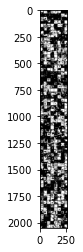

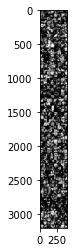

512
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 3, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0,
        4, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 0,
        3, 0, 0, 2, 4, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0,
        0, 0, 0, 3, 1, 2, 3, 0, 0, 3, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2,
        0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 1, 0, 1, 1, 0, 1, 1, 0, 0, 3, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
        1, 0, 3, 0, 0, 0, 0, 0, 0, 0

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.1786, 0.4739, 0.5329])
#     std = np.array([[0.0632, 0.1361, 0.0606]])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

start = time.time()

SAR, EO = next(iter(data_loader))
end = time.time()
print(end - start)
# Get a batch of training data
EO_inputs, EO_classes = EO[0],EO[1]


inputs, classes = SAR[0],SAR[1]


# EO_class_names = SAR_EO_Combine.image_label



# Make a grid from batch
EO_out = torchvision.utils.make_grid(EO_inputs)

out = torchvision.utils.make_grid(inputs)
imshow(EO_out)#, title=[EO_class_names[x] for x in classes])

imshow(out)#, title=[class_names[x] for x in classes])
print(len(EO_classes))
print(classes)

### check if paired succeed

In [20]:
# from tqdm import trange
# def equal():
#     notsame_image = 0
#     notsame_label = 0
#     t = trange(len(sar_df))
    

    
#     for i in t:
#         t.set_postfix({'nums of not same label:': notsame_label})
#         sar, eo = next(iter(data_loader))
#         eo_label = eo[1][0].tolist()
#         sar_label = sar[1][0].tolist()
# #         print(eo_label)
# #         print(sar_label)
#     #     if not eo_image == sar_image:
#     #         notsame_image += 1
        
# #             eoval = next(eo_label) 
# #             sarval = next(sar_label) 
#         if not eo_label==sar_label:
#             notsame_label += 1
        
# #         notsame_label += 1
# #     print("nums of not same imageid:", notsame_image)
#         #print("nums of not same label:", notsame_label)

# equal()
# #next(iter(data_loader))

In [21]:
len(sar_df) == len(eo_df)

True

In [22]:
next(eo_df.iterrows())[1]

img_name    EO_0.png
class_id           0
Name: 0, dtype: object

In [23]:
Num_class=10
num_classes = Num_class
num_channel = 1

model_ft = models.resnet34(pretrained=False)

model_ft.conv1 = nn.Conv2d(num_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
# model_ft.avgpool = SpatialPyramidPooling((3,3))
model_ft.fc = nn.Linear(512, Num_class)
# model_ft.conv0 = nn.Conv2d(
# model_ft.features[0] = nn.Conv2d(num_channel, 16, kernel_size=3, stride=2, padding=1,bias=False)
# model_ft.classifier[3] = nn.Linear(1024, Num_class, bias=True)
model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
data_dir = '/mnt/sda1/cvpr21/Classification/ram'
weights = []
for i in range(len(os.listdir(os.path.join(data_dir, "Training")))):
    img_num = len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))])
    print('filenum:',len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))]))# if os.path.isfile(os.path.join(data_dir, lists))]))
    weights.append(img_num)
print(weights)
weights = torch.tensor(weights, dtype=torch.float32).cuda()
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)

filenum: 234135
filenum: 28030
filenum: 15234
filenum: 10587
filenum: 1668
filenum: 782
filenum: 768
filenum: 562
filenum: 783
filenum: 573
[234135, 28030, 15234, 10587, 1668, 782, 768, 562, 783, 573]
tensor([0.7988, 0.0956, 0.0520, 0.0361, 0.0057, 0.0027, 0.0026, 0.0019, 0.0027,
        0.0020], device='cuda:0')
tensor([0.0005, 0.0044, 0.0080, 0.0115, 0.0733, 0.1563, 0.1591, 0.2175, 0.1561,
        0.2133], device='cuda:0')


### Teacher model (EO)

In [25]:
netT = torch.load('29_auto_aug_eo_sar_noimagenet/pre_resnet34_eo_epoch99.pt')
criterion2 = nn.KLDivLoss(reduction="none")
netT.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training Processing

In [26]:
from tqdm.notebook import trange
from tqdm import tqdm_notebook as tqdm
import warnings
import time

warnings.filterwarnings('ignore')


def train_model(model, criterion, optimizer, scheduler, num_epochs,eo_sar):
    since = time.time()
#     print("---------------Start KD iteration-----------------")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    if eo_sar == "EO":
        kd_alpha = 0.2
        T = 2
    elif eo_sar == "SAR":
        kd_alpha = 0.8
        T = 2

    Loss_list = []
    Accuracy_list = []
    T_Loss_list = []
    T_Accuracy_list = []

    for epoch in trange(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Test']:  # ['Test','Training']: #:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.

            if phase == 'Training':

                for SAR, EO in tqdm(data_loader):
#                     start = time.time()


                    if eo_sar == "EO":
                        inputs, labels = EO[0], EO[1]
                        inputs = inputs.to(device)

                        labels = labels.to(device)

                        T_input, T_labels = SAR[0], SAR[1]
                        T_input = T_input.to(device)
                        T_labels = T_labels.to(device)
                    elif eo_sar == "SAR":
                        inputs, labels = SAR[0], SAR[1]
                        inputs = inputs.to(device)

                        labels = labels.to(device)

                        T_input, T_labels = EO[0], EO[1]
                        T_input = T_input.to(device)
                        T_labels = T_labels.to(device)
                        
#                     end = time.time()
#                     print(end - start)
                    #                 print(T_labels, labels)
                    #                 labels = torch.argmax(labels, 0)
                    #                 T_labels = torch.argmax(T_labels, 0)

                    #                     confusion_matrix = torch.zeros(10, 10)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.no_grad():
                        soft_target = netT(T_input)
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)  # _,
                        # print(outputs.dim())

                        _, preds = torch.max(outputs, 1)

                        #                         for t, p in zip(labels.view(-1), preds.view(-1)):
                        #                             confusion_matrix[t.long(), p.long()] += 1
                        #                         print(confusion_matrix.diag()/confusion_matrix.sum(1))

                        #                     _, T_preds = torch.max(soft_target, 1)

                        outputs_S = F.log_softmax(outputs / T, dim=1)
                        outputs_T = F.softmax(soft_target / T, dim=1)
                        #                     print(outputs_S.size())
                        #                     print(outputs_T.size())

                        loss2 = criterion2(outputs_S, outputs_T) * T * T *weights
                        loss2 = loss2.mean()

                        # print(preds)

                        if phase == 'Training':
                            inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                            inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
                            #                         print(y_a)
                            #                         print(y_b)

                            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                            loss = loss * (1 - kd_alpha) + loss2 * kd_alpha
                        else:

                            loss = criterion(outputs, labels)
                            loss = loss * (1 - kd_alpha) + loss2 * kd_alpha

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if phase == "Training":
                    Loss_list.append(epoch_loss)
                    Accuracy_list.append(100 * epoch_acc)
                else:
                    T_Loss_list.append(epoch_loss)
                    T_Accuracy_list.append(100 * epoch_acc)

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    PATH = os.path.join(str(exp_num),
                                        "resnet34_kd_best.pt")  # "resnet18_model_epoch{}.pt".format(epoch)
                    if not os.path.exists(str(exp_num)):
                        os.makedirs(str(exp_num))
                    torch.save(model, PATH)
                    time_elapsed = time.time() - since
                    print('Time from Start {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))

                if phase == 'Training' and epoch_acc > best_train_acc:
                    best_train_acc = epoch_acc
            #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
            #                 if not os.path.exists(str(exp_num)):
            #                     os.makedirs(str(exp_num))
            #                 torch.save(model, PATH)

            #############################################################################
            elif phase == 'Test':
                acc_matrix_sum = torch.zeros(10)

                for SAR, EO in tqdm(test_loader):
                    if eo_sar == "EO":
                        inputs, labels = EO[0], EO[1]
                        inputs = inputs.to(device)

                        labels = labels.to(device)

                        T_input, T_labels = SAR[0], SAR[1]
                        T_input = T_input.to(device)
                        T_labels = T_labels.to(device)
                    elif eo_sar == "SAR":
                        inputs, labels = SAR[0], SAR[1]
                        inputs = inputs.to(device)

                        labels = labels.to(device)

                        T_input, T_labels = EO[0], EO[1]
                        T_input = T_input.to(device)
                        T_labels = T_labels.to(device)
                    #                 print(T_labels, labels)
                    #                 labels = torch.argmax(labels, 0)
                    #                 T_labels = torch.argmax(T_labels, 0)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.no_grad():
                        soft_target = netT(T_input)
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)  # _,
                        # print(outputs.dim())

                        _, preds = torch.max(outputs, 1)

                        confusion_matrix = torch.zeros(10, 10)
                        for t, p in zip(labels.view(-1), preds.view(-1)):
                            confusion_matrix[t.long(), p.long()] += 1
                        acc_matrix_batch = (confusion_matrix.diag() / confusion_matrix.sum(1))

                        #                     _, T_preds = torch.max(soft_target, 1)

                        outputs_S = F.log_softmax(outputs / T, dim=1)
                        outputs_T = F.softmax(soft_target / T, dim=1)
                        #                     print(outputs_S.size())
                        #                     print(outputs_T.size())

                        loss2 = criterion2(outputs_S, outputs_T) * T * T * weights
                        loss2 = loss2.mean()
                        # print(preds)

                        if phase == 'Training':
                            inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                            inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
                            #                         print(y_a)
                            #                         print(y_b)

                            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                            loss = loss * (1 - kd_alpha) + loss2 * kd_alpha
                        else:

                            loss = criterion(outputs, labels)
                            loss = loss * (1 - kd_alpha) + loss2 * kd_alpha

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    acc_matrix_sum += acc_matrix_batch

                acc_matrix = acc_matrix_sum / test_size
                print("acc for each class: {}".format(acc_matrix))
                #################

                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if phase == "Training":
                    Loss_list.append(epoch_loss)
                    Accuracy_list.append(100 * epoch_acc)
                else:
                    T_Loss_list.append(epoch_loss)
                    T_Accuracy_list.append(100 * epoch_acc)

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    PATH = os.path.join(str(exp_num),
                                        "{}iter{}_resnet34_kd_best.pt".format(eo_sar, iter_num))  # "resnet18_model_epoch{}.pt".format(epoch)
                    if not os.path.exists(str(exp_num)):
                        os.makedirs(str(exp_num))
                    torch.save(model, PATH)
                    time_elapsed = time.time() - since
                    print('Time from Start {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))

                if phase == 'Training' and epoch_acc > best_train_acc:
                    best_train_acc = epoch_acc
        #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
        #                 if not os.path.exists(str(exp_num)):
        #                     os.makedirs(str(exp_num))
        #                 torch.save(model, PATH)

        print()
        PATH = os.path.join(str(exp_num), "{}iter{}_resnet34_kd{}.pt".format(eo_sar,iter_num,epoch))  # "resnet18_model_epoch{}.pt".format(epoch)
        if not os.path.exists(str(exp_num)):
            os.makedirs(str(exp_num))
        torch.save(model, PATH)
    #         torch.save(best_model_wts, "best.pt")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    ##### PLOT
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.show()
    plt.savefig("Train_accuracy_loss.jpg")

    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = T_Accuracy_list
    y2 = T_Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()
    plt.savefig("Test_accuracy_loss.jpg")

    return model


def iter_train():
    global iter_num
    global iter_numer
    
    for i in trange(iter_numer):
        print("---------------Start KD iteration_{}-----------------".format(i))
        for eo_sar in ["EO", "SAR"]:
            print("---------------Training_for_{}-----------------".format(eo_sar))
            if eo_sar == "EO":
                eo_sar_instead = "SAR"
            else:
                eo_sar_instead = "EO"
            if i == 0: ## first iter
                netT = torch.load("10/resnet34_model_epoch119.pt")
                model_ft = torch.load("10/pre_resnet34_model_epoch99.pt")




            else: ## rest of iter
                if eo_sar == "EO": ## train eo model
                    netT = torch.load(os.path.join(str(exp_num),"{}iter{}_resnet34_kd_best.pt".format(eo_sar_instead,iter_num-1)))
                    model_ft = torch.load(os.path.join(str(exp_num),"{}iter{}_resnet34_kd_best.pt".format(eo_sar,iter_num-1)))
                else: ## train sar model
                    netT = torch.load(os.path.join(str(exp_num), "{}iter{}_resnet34_kd_best.pt".format(eo_sar_instead, iter_num)))
                    model_ft = torch.load(os.path.join(str(exp_num), "{}iter{}_resnet34_kd_best.pt".format(eo_sar, iter_num - 1)))

            if i == 0:
                optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
            else:

                lr_rate = 0.01 * (0.5 ** iter_num)

                optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_rate, momentum=0.9)

            # Decay LR by a factor
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.5)
                
            num_epochs = 20

            model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                   num_epochs,eo_sar)


        iter_num += 1


model_ft = model_ft.to(device)

# #criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=weights) #weight=weights, 

In [27]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()
#     print("---------------Start KD FIT( TEACHER AND STUDENT )-----------------")
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     best_train_acc = 0.0
    
#     kd_alpha = 0.8
    
#     Loss_list = []
#     Accuracy_list = []
#     T_Loss_list = []
#     T_Accuracy_list = []

#     for epoch in trange(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
#         # Each epoch has a training and validation phase
#         for phase in ['Training', 'Test']:
#             ##################################### train#############################
#             if phase == 'Training':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             if phase == "Training":
#                 for SAR, EO in tqdm(data_loader):
#                     inputs, labels = SAR[0], SAR[1]
#                     inputs = inputs.to(device)

#                     labels = labels.to(device)

#                     T_input, T_labels = EO[0], EO[1]
#                     T_input = T_input.to(device)
#                     T_labels = T_labels.to(device)
#         #                 print(T_labels, labels)
#         #                 labels = torch.argmax(labels, 0)
#         #                 T_labels = torch.argmax(T_labels, 0)


#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.no_grad():
#                         soft_target = netT(T_input)
#                     with torch.set_grad_enabled():
#                         outputs = model(inputs) # _, 
#                         #print(outputs.dim())

#                         _, preds = torch.max(outputs, 1)


#         #                     _, T_preds = torch.max(soft_target, 1)
#                         T = 2
#                         outputs_S = F.log_softmax(outputs/T, dim=1)
#                         outputs_T = F.softmax(soft_target/T, dim=1)
#         #                     print(outputs_S.size())
#         #                     print(outputs_T.size())

#                         loss2 = criterion2(outputs_S, outputs_T) * T * T
#                         #print(preds)


#                         inputs, y_a, y_b, lam = mixup_data(inputs, labels)
#                         inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
#     #                         print(y_a)
#     #                         print(y_b)

#                         loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
#                         loss = loss*(1-kd_alpha) + loss2*kd_alpha
#                         running_loss += loss.item() * inputs.size(0)
#                         running_corrects += torch.sum(preds == labels.data) 

#                         loss.backward()
#                         optimizer.step()
#                         scheduler.step()

        
        
#         ##############################test#############################
#             else:
#                 for SAR, EO in tqdm(test_data_loader):
#                     inputs, labels = SAR[0], SAR[1]
#                     inputs = inputs.to(device)

#                     labels = labels.to(device)

#                     T_input, T_labels = EO[0], EO[1]
#                     T_input = T_input.to(device)
#                     T_labels = T_labels.to(device)




#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.no_grad():
#                         soft_target = netT(T_input)

#                     outputs = model(inputs) # _, 
#                         #print(outputs.dim())

#                     _, preds = torch.max(outputs, 1)


#     #                     _, T_preds = torch.max(soft_target, 1)
#                     T = 2
#                     outputs_S = F.log_softmax(outputs/T, dim=1)
#                     outputs_T = F.softmax(soft_target/T, dim=1)
#     #                     print(outputs_S.size())
#     #                     print(outputs_T.size())

#                     loss2 = criterion2(outputs_S, outputs_T) * T * T

#                     loss = criterion(outputs, labels)
#                     loss = loss*(1-kd_alpha) + loss2*kd_alpha
#                 ################################

#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)    
                
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             if phase == "Training":
#                 Loss_list.append(epoch_loss)
#                 Accuracy_list.append(100 * epoch_acc)
#             else:
#                 T_Loss_list.append(epoch_loss)
#                 T_Accuracy_list.append(100 * epoch_acc)



#             # deep copy the model
#             if phase == 'Test' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
#                 if not os.path.exists(str(exp_num)):
#                     os.makedirs(str(exp_num))
#                 torch.save(model, PATH)
#                 time_elapsed = time.time() - since
#                 print('Time from Start {:.0f}m {:.0f}s'.format(
#                     time_elapsed // 60, time_elapsed % 60))

#             if phase == 'Training' and epoch_acc > best_train_acc:
#                 best_train_acc = epoch_acc
#     #                 PATH = os.path.join(str(exp_num), "resnet34_kd_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
#     #                 if not os.path.exists(str(exp_num)):
#     #                     os.makedirs(str(exp_num))
#     #                 torch.save(model, PATH)
#         print()
#         PATH = os.path.join(str(exp_num), "resnet34_kd{}.pt".format(epoch))#"resnet18_model_epoch{}.pt".format(epoch)
#         if not os.path.exists(str(exp_num)):
#             os.makedirs(str(exp_num))
#         torch.save(model, PATH)
        
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best train Acc: {:4f}'.format(best_train_acc))
#     print('Best val Acc: {:4f}'.format(best_acc))
    

#     # load best model weights
#     model.load_state_dict(best_model_wts)
    
    
#     ##### PLOT
#     x1 = range(0, num_epochs)
#     x2 = range(0, num_epochs)
#     y1 = Accuracy_list
#     y2 = Loss_list
#     plt.subplot(2, 1, 1)
#     plt.plot(x1, y1, 'o-')
#     plt.title('Train accuracy vs. epoches')
#     plt.ylabel('Train accuracy')
#     plt.subplot(2, 1, 2)
#     plt.plot(x2, y2, '.-')
#     plt.xlabel('Train loss vs. epoches')
#     plt.ylabel('Train loss')
#     plt.show()
#     plt.savefig("Train_accuracy_loss.jpg")
    
#     x1 = range(0, num_epochs)
#     x2 = range(0, num_epochs)
#     y1 = T_Accuracy_list
#     y2 = T_Loss_list
#     plt.subplot(2, 1, 1)
#     plt.plot(x1, y1, 'o-')
#     plt.title('Test accuracy vs. epoches')
#     plt.ylabel('Test accuracy')
#     plt.subplot(2, 1, 2)
#     plt.plot(x2, y2, '.-')
#     plt.xlabel('Test loss vs. epoches')
#     plt.ylabel('Test loss')
#     plt.show()
#     plt.savefig("Test_accuracy_loss.jpg")
    
#     return model


# model_ft = model_ft.to(device)

# # #criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=weights) #weight=weights, 
        
                
                

In [28]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [29]:
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=120)

## Fitting, log include in this block

---------------Start KD iteration_0-----------------
---------------Training_for_EO-----------------


Epoch 0/19



Training Loss: 1.4577 Acc: 0.4874



acc for each class: tensor([0.0012, 0.0012, 0.0021, 0.0017, 0.0024, 0.0020, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1728 Acc: 0.8335
Time from Start 2m 8s

Epoch 1/19



Training Loss: 1.4014 Acc: 0.4905



acc for each class: tensor([0.0009, 0.0018, 0.0022, 0.0024, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1326 Acc: 0.8923
Time from Start 4m 16s

Epoch 2/19



Training Loss: 1.3405 Acc: 0.5444



acc for each class: tensor([0.0011, 0.0016, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0020, 0.0024,
        0.0024])
Test Loss: 0.1378 Acc: 0.8874

Epoch 3/19



Training Loss: 1.3388 Acc: 0.5622



acc for each class: tensor([0.0014, 0.0018, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1793 Acc: 0.8947
Time from Start 8m 31s

Epoch 4/19



Training Loss: 1.3494 Acc: 0.5707



acc for each class: tensor([0.0016, 0.0021, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1378 Acc: 0.9376
Time from Start 10m 37s

Epoch 5/19



Training Loss: 1.3308 Acc: 0.5947



acc for each class: tensor([0.0014, 0.0018, 0.0023, 0.0022, 0.0024, 0.0021, 0.0024, 0.0022, 0.0024,
        0.0024])
Test Loss: 0.1328 Acc: 0.9058

Epoch 6/19



Training Loss: 1.3548 Acc: 0.5270



acc for each class: tensor([0.0017, 0.0021, 0.0024, 0.0023, 0.0024, 0.0021, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1223 Acc: 0.9217

Epoch 7/19



Training Loss: 1.3756 Acc: 0.5042



acc for each class: tensor([0.0011, 0.0015, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0020, 0.0024,
        0.0024])
Test Loss: 0.3471 Acc: 0.8690

Epoch 8/19



Training Loss: 1.3906 Acc: 0.5191



acc for each class: tensor([0.0015, 0.0022, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1260 Acc: 0.9339

Epoch 9/19



Training Loss: 1.3144 Acc: 0.5791



acc for each class: tensor([0.0014, 0.0016, 0.0021, 0.0022, 0.0024, 0.0021, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1669 Acc: 0.8739

Epoch 10/19



Training Loss: 1.4163 Acc: 0.4857



acc for each class: tensor([0.0012, 0.0016, 0.0021, 0.0021, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1574 Acc: 0.8641

Epoch 11/19



Training Loss: 1.4212 Acc: 0.4599



acc for each class: tensor([0.0013, 0.0019, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1449 Acc: 0.9021

Epoch 12/19



Training Loss: 1.3558 Acc: 0.5071



acc for each class: tensor([0.0015, 0.0021, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.1480 Acc: 0.9155

Epoch 13/19



Training Loss: 1.5801 Acc: 0.3680



acc for each class: tensor([0.0006, 0.0013, 0.0022, 0.0020, 0.0024, 0.0022, 0.0024, 0.0021, 0.0024,
        0.0023])
Test Loss: 0.1777 Acc: 0.8262

Epoch 14/19



Training Loss: 1.4139 Acc: 0.4290



acc for each class: tensor([0.0012, 0.0012, 0.0020, 0.0019, 0.0024, 0.0022, 0.0024, 0.0021, 0.0021,
        0.0024])
Test Loss: 0.4891 Acc: 0.8213

Epoch 15/19



Training Loss: 1.3862 Acc: 0.4445



acc for each class: tensor([0.0012, 0.0018, 0.0021, 0.0021, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1512 Acc: 0.8813

Epoch 16/19



Training Loss: 1.3483 Acc: 0.5022



acc for each class: tensor([0.0015, 0.0020, 0.0024, 0.0024, 0.0024, 0.0021, 0.0024, 0.0022, 0.0024,
        0.0024])
Test Loss: 0.1592 Acc: 0.9131

Epoch 17/19



Training Loss: 1.3044 Acc: 0.5485



acc for each class: tensor([0.0014, 0.0021, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1235 Acc: 0.9217

Epoch 18/19



Training Loss: 1.2714 Acc: 0.5782



acc for each class: tensor([0.0017, 0.0021, 0.0023, 0.0023, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.1288 Acc: 0.9327

Epoch 19/19



Training Loss: 1.3094 Acc: 0.6018



acc for each class: tensor([0.0016, 0.0018, 0.0023, 0.0024, 0.0024, 0.0021, 0.0024, 0.0021, 0.0024,
        0.0024])
Test Loss: 0.2837 Acc: 0.9045


Training complete in 43m 6s
Best train Acc: 0.601836
Best val Acc: 0.937576


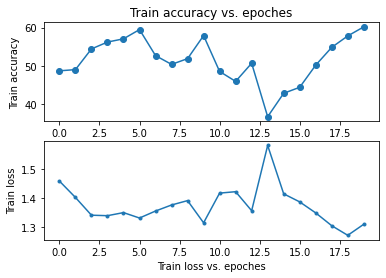

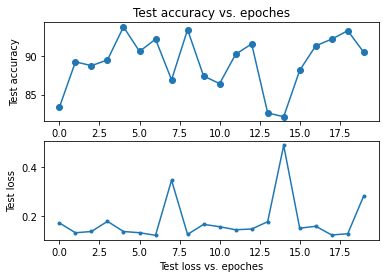

---------------Training_for_SAR-----------------


Epoch 0/19



Training Loss: 0.4537 Acc: 0.1917



acc for each class: tensor([7.3939e-05, 1.9817e-04, 4.8999e-04, 6.6118e-04, 1.3602e-03, 3.7091e-05,
        1.3714e-03, 2.1217e-03, 1.3280e-03, 1.7550e-03])
Test Loss: 0.3389 Acc: 0.4002
Time from Start 2m 54s

Epoch 1/19



Training Loss: 0.4341 Acc: 0.0957



acc for each class: tensor([1.9102e-04, 9.7919e-05, 5.4400e-04, 1.0441e-03, 1.9105e-03, 7.7590e-04,
        1.7453e-03, 2.2436e-03, 1.6226e-03, 1.8587e-03])
Test Loss: 0.5343 Acc: 0.5104
Time from Start 5m 50s

Epoch 2/19



Training Loss: 0.4227 Acc: 0.0906



acc for each class: tensor([0.0001, 0.0004, 0.0008, 0.0009, 0.0021, 0.0014, 0.0019, 0.0022, 0.0021,
        0.0022])
Test Loss: 0.2218 Acc: 0.5912
Time from Start 8m 45s

Epoch 3/19



Training Loss: 0.4162 Acc: 0.0909



acc for each class: tensor([0.0001, 0.0004, 0.0008, 0.0009, 0.0021, 0.0017, 0.0019, 0.0022, 0.0023,
        0.0021])
Test Loss: 0.1953 Acc: 0.6120
Time from Start 11m 39s

Epoch 4/19



Training Loss: 0.4095 Acc: 0.1037



acc for each class: tensor([0.0002, 0.0006, 0.0011, 0.0010, 0.0021, 0.0014, 0.0019, 0.0023, 0.0022,
        0.0020])
Test Loss: 0.1874 Acc: 0.6193
Time from Start 14m 35s

Epoch 5/19



Training Loss: 0.4046 Acc: 0.1167



acc for each class: tensor([0.0004, 0.0005, 0.0013, 0.0011, 0.0023, 0.0013, 0.0019, 0.0024, 0.0022,
        0.0022])
Test Loss: 0.2108 Acc: 0.6561
Time from Start 17m 29s

Epoch 6/19



Training Loss: 0.4082 Acc: 0.1301



acc for each class: tensor([0.0003, 0.0006, 0.0013, 0.0009, 0.0022, 0.0017, 0.0019, 0.0024, 0.0022,
        0.0015])
Test Loss: 0.2077 Acc: 0.6316

Epoch 7/19



Training Loss: 0.3991 Acc: 0.1291



acc for each class: tensor([0.0003, 0.0008, 0.0015, 0.0013, 0.0022, 0.0017, 0.0022, 0.0024, 0.0022,
        0.0021])
Test Loss: 0.1859 Acc: 0.6916
Time from Start 24m 24s

Epoch 8/19



Training Loss: 0.3989 Acc: 0.1318



acc for each class: tensor([0.0003, 0.0009, 0.0015, 0.0016, 0.0023, 0.0018, 0.0022, 0.0023, 0.0023,
        0.0020])
Test Loss: 0.1590 Acc: 0.7062
Time from Start 29m 51s

Epoch 9/19



Training Loss: 0.3946 Acc: 0.1346



acc for each class: tensor([0.0003, 0.0008, 0.0014, 0.0013, 0.0023, 0.0018, 0.0020, 0.0023, 0.0022,
        0.0022])
Test Loss: 0.1432 Acc: 0.7062

Epoch 10/19



Training Loss: 0.3957 Acc: 0.1381



acc for each class: tensor([0.0003, 0.0008, 0.0013, 0.0014, 0.0022, 0.0017, 0.0023, 0.0023, 0.0023,
        0.0022])
Test Loss: 0.1350 Acc: 0.7099
Time from Start 40m 52s

Epoch 11/19



Training Loss: 0.3932 Acc: 0.1387



acc for each class: tensor([0.0003, 0.0010, 0.0017, 0.0013, 0.0023, 0.0018, 0.0022, 0.0024, 0.0020,
        0.0021])
Test Loss: 0.1466 Acc: 0.7185
Time from Start 46m 6s

Epoch 12/19



Training Loss: 0.3961 Acc: 0.1377



acc for each class: tensor([0.0003, 0.0011, 0.0014, 0.0015, 0.0022, 0.0016, 0.0022, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1427 Acc: 0.7222
Time from Start 51m 36s

Epoch 13/19



Training Loss: 0.3904 Acc: 0.1411



acc for each class: tensor([0.0004, 0.0008, 0.0014, 0.0016, 0.0023, 0.0019, 0.0023, 0.0024, 0.0024,
        0.0021])
Test Loss: 0.1186 Acc: 0.7368
Time from Start 56m 57s

Epoch 14/19



Training Loss: 0.3953 Acc: 0.1496



acc for each class: tensor([0.0003, 0.0008, 0.0015, 0.0015, 0.0024, 0.0018, 0.0023, 0.0024, 0.0023,
        0.0022])
Test Loss: 0.1298 Acc: 0.7356

Epoch 15/19



Training Loss: 0.3899 Acc: 0.1522



acc for each class: tensor([0.0004, 0.0008, 0.0017, 0.0014, 0.0023, 0.0019, 0.0023, 0.0024, 0.0023,
        0.0021])
Test Loss: 0.1326 Acc: 0.7319

Epoch 16/19



Training Loss: 0.3847 Acc: 0.1551



acc for each class: tensor([0.0003, 0.0008, 0.0015, 0.0015, 0.0022, 0.0017, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1126 Acc: 0.7283

Epoch 17/19



Training Loss: 0.3874 Acc: 0.1651



acc for each class: tensor([0.0003, 0.0012, 0.0016, 0.0015, 0.0023, 0.0013, 0.0021, 0.0023, 0.0023,
        0.0023])
Test Loss: 0.1454 Acc: 0.7246

Epoch 18/19



Training Loss: 0.3864 Acc: 0.1676



acc for each class: tensor([0.0005, 0.0010, 0.0017, 0.0015, 0.0021, 0.0019, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1233 Acc: 0.7491
Time from Start 84m 9s

Epoch 19/19



Training Loss: 0.3873 Acc: 0.1720



acc for each class: tensor([0.0004, 0.0012, 0.0018, 0.0015, 0.0024, 0.0017, 0.0023, 0.0023, 0.0024,
        0.0023])
Test Loss: 0.1266 Acc: 0.7625
Time from Start 89m 38s


Training complete in 89m 39s
Best train Acc: 0.191670
Best val Acc: 0.762546


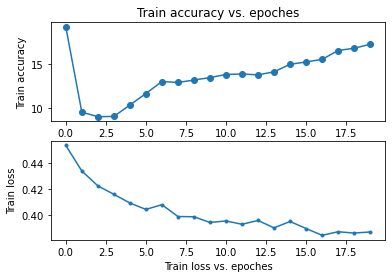

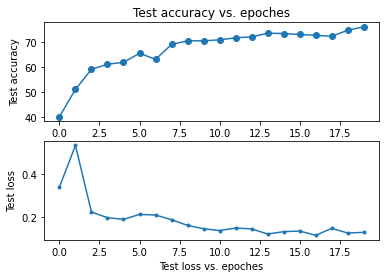

---------------Start KD iteration_1-----------------
---------------Training_for_EO-----------------


Epoch 0/19



Training Loss: 1.2741 Acc: 0.6251



acc for each class: tensor([0.0016, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0791 Acc: 0.9437
Time from Start 3m 47s

Epoch 1/19



Training Loss: 1.2556 Acc: 0.6377



acc for each class: tensor([0.0016, 0.0020, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.0825 Acc: 0.9437

Epoch 2/19



Training Loss: 1.2459 Acc: 0.6743



acc for each class: tensor([0.0020, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.0872 Acc: 0.9572
Time from Start 11m 24s

Epoch 3/19



Training Loss: 1.2469 Acc: 0.6682



acc for each class: tensor([0.0021, 0.0022, 0.0014, 0.0024, 0.0024, 0.0023, 0.0024, 0.0023, 0.0024,
        0.0024])
Test Loss: 0.0962 Acc: 0.9168

Epoch 4/19



Training Loss: 1.2808 Acc: 0.6689



acc for each class: tensor([0.0019, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0797 Acc: 0.9572

Epoch 5/19



Training Loss: 1.2595 Acc: 0.6793



acc for each class: tensor([0.0018, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0852 Acc: 0.9535

Epoch 6/19



Training Loss: 1.2871 Acc: 0.6650



acc for each class: tensor([0.0019, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1026 Acc: 0.9608
Time from Start 26m 48s

Epoch 7/19



Training Loss: 1.2579 Acc: 0.6590



acc for each class: tensor([0.0020, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0691 Acc: 0.9621
Time from Start 30m 43s

Epoch 8/19



Training Loss: 1.3019 Acc: 0.6404



acc for each class: tensor([0.0017, 0.0020, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0022, 0.0024,
        0.0024])
Test Loss: 0.1136 Acc: 0.9425

Epoch 9/19



Training Loss: 1.2725 Acc: 0.6609



acc for each class: tensor([0.0020, 0.0020, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.1084 Acc: 0.9572

Epoch 10/19



Training Loss: 1.2607 Acc: 0.6828



acc for each class: tensor([0.0021, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0741 Acc: 0.9657
Time from Start 42m 22s

Epoch 11/19



Training Loss: 1.2363 Acc: 0.6816



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0972 Acc: 0.9694
Time from Start 46m 24s

Epoch 12/19



Training Loss: 1.2503 Acc: 0.7015



acc for each class: tensor([0.0021, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0579 Acc: 0.9682

Epoch 13/19



Training Loss: 1.2555 Acc: 0.7131



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0845 Acc: 0.9706
Time from Start 54m 12s

Epoch 14/19



Training Loss: 1.2441 Acc: 0.7124



acc for each class: tensor([0.0021, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0604 Acc: 0.9682

Epoch 15/19



Training Loss: 1.2757 Acc: 0.7163



acc for each class: tensor([0.0022, 0.0022, 0.0023, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0831 Acc: 0.9682

Epoch 16/19



Training Loss: 1.2405 Acc: 0.7106



acc for each class: tensor([0.0021, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0789 Acc: 0.9694

Epoch 17/19



Training Loss: 1.2322 Acc: 0.7390



acc for each class: tensor([0.0022, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0858 Acc: 0.9731
Time from Start 70m 4s

Epoch 18/19



Training Loss: 1.2863 Acc: 0.7218



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0527 Acc: 0.9743
Time from Start 73m 55s

Epoch 19/19



Training Loss: 1.2661 Acc: 0.7310



acc for each class: tensor([0.0022, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0661 Acc: 0.9743


Training complete in 77m 49s
Best train Acc: 0.739023
Best val Acc: 0.974296


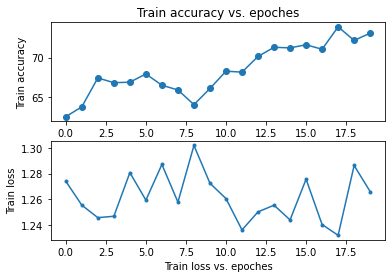

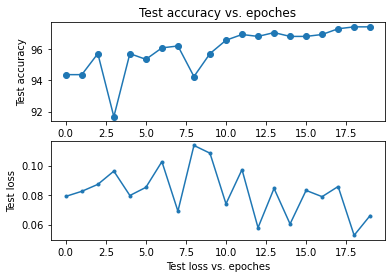

---------------Training_for_SAR-----------------


Epoch 0/19



Training Loss: 0.3819 Acc: 0.1771



acc for each class: tensor([0.0004, 0.0012, 0.0018, 0.0014, 0.0024, 0.0018, 0.0022, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1205 Acc: 0.7540
Time from Start 5m 29s

Epoch 1/19



Training Loss: 0.3826 Acc: 0.1863



acc for each class: tensor([0.0004, 0.0012, 0.0016, 0.0016, 0.0023, 0.0020, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1103 Acc: 0.7723
Time from Start 10m 60s

Epoch 2/19



Training Loss: 0.3835 Acc: 0.1942



acc for each class: tensor([0.0005, 0.0013, 0.0018, 0.0014, 0.0024, 0.0018, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.1104 Acc: 0.7736
Time from Start 16m 31s

Epoch 3/19



Training Loss: 0.3791 Acc: 0.1884



acc for each class: tensor([0.0005, 0.0010, 0.0017, 0.0015, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1105 Acc: 0.7699

Epoch 4/19



Training Loss: 0.3815 Acc: 0.1897



acc for each class: tensor([0.0004, 0.0014, 0.0018, 0.0015, 0.0024, 0.0018, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.1119 Acc: 0.7736

Epoch 5/19



Training Loss: 0.3767 Acc: 0.1949



acc for each class: tensor([0.0004, 0.0014, 0.0016, 0.0017, 0.0024, 0.0020, 0.0024, 0.0024, 0.0023,
        0.0023])
Test Loss: 0.1113 Acc: 0.7772
Time from Start 32m 51s

Epoch 6/19



Training Loss: 0.3779 Acc: 0.2001



acc for each class: tensor([0.0005, 0.0011, 0.0018, 0.0015, 0.0024, 0.0020, 0.0024, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.1061 Acc: 0.7785
Time from Start 38m 19s

Epoch 7/19



Training Loss: 0.3736 Acc: 0.2049



acc for each class: tensor([0.0005, 0.0012, 0.0016, 0.0017, 0.0024, 0.0018, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1085 Acc: 0.7687

Epoch 8/19



Training Loss: 0.3755 Acc: 0.1995



acc for each class: tensor([0.0004, 0.0012, 0.0019, 0.0016, 0.0024, 0.0019, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1092 Acc: 0.7895
Time from Start 48m 56s

Epoch 9/19



Training Loss: 0.3760 Acc: 0.1989



acc for each class: tensor([0.0006, 0.0012, 0.0019, 0.0014, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0021])
Test Loss: 0.1117 Acc: 0.7797

Epoch 10/19



Training Loss: 0.3800 Acc: 0.2018



acc for each class: tensor([0.0006, 0.0013, 0.0015, 0.0016, 0.0023, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1038 Acc: 0.7870

Epoch 11/19



Training Loss: 0.3753 Acc: 0.2049



acc for each class: tensor([0.0006, 0.0013, 0.0017, 0.0016, 0.0023, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1059 Acc: 0.7907
Time from Start 65m 24s

Epoch 12/19



Training Loss: 0.3745 Acc: 0.2150



acc for each class: tensor([0.0007, 0.0012, 0.0017, 0.0015, 0.0024, 0.0020, 0.0024, 0.0024, 0.0024,
        0.0021])
Test Loss: 0.1056 Acc: 0.7846

Epoch 13/19



Training Loss: 0.3730 Acc: 0.2081



acc for each class: tensor([0.0006, 0.0014, 0.0019, 0.0016, 0.0024, 0.0020, 0.0024, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.1113 Acc: 0.8017
Time from Start 75m 53s

Epoch 14/19



Training Loss: 0.3757 Acc: 0.2141



acc for each class: tensor([0.0005, 0.0013, 0.0018, 0.0017, 0.0023, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0955 Acc: 0.7956

Epoch 15/19



Training Loss: 0.3711 Acc: 0.2113



acc for each class: tensor([0.0006, 0.0011, 0.0018, 0.0016, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0971 Acc: 0.7895

Epoch 16/19



Training Loss: 0.3762 Acc: 0.2120



acc for each class: tensor([0.0007, 0.0012, 0.0018, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.1013 Acc: 0.8005

Epoch 17/19



Training Loss: 0.3757 Acc: 0.2083



acc for each class: tensor([0.0005, 0.0013, 0.0017, 0.0017, 0.0024, 0.0018, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1129 Acc: 0.7785

Epoch 18/19



Training Loss: 0.3740 Acc: 0.2221



acc for each class: tensor([0.0006, 0.0011, 0.0018, 0.0017, 0.0023, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0951 Acc: 0.7993

Epoch 19/19



Training Loss: 0.3798 Acc: 0.2188



acc for each class: tensor([0.0006, 0.0013, 0.0018, 0.0016, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0022])
Test Loss: 0.1014 Acc: 0.8005


Training complete in 108m 21s
Best train Acc: 0.222101
Best val Acc: 0.801714


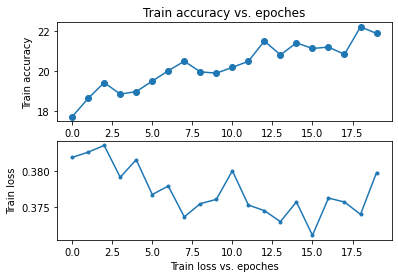

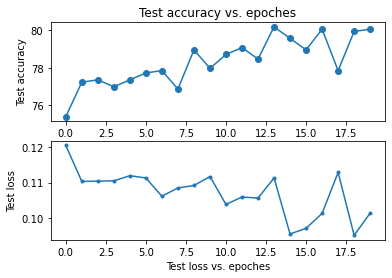

---------------Start KD iteration_2-----------------
---------------Training_for_EO-----------------


Epoch 0/19



Training Loss: 1.2438 Acc: 0.7361



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0613 Acc: 0.9767
Time from Start 3m 49s

Epoch 1/19



Training Loss: 1.1798 Acc: 0.7415



acc for each class: tensor([0.0023, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0536 Acc: 0.9755

Epoch 2/19



Training Loss: 1.1787 Acc: 0.7491



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0662 Acc: 0.9780
Time from Start 11m 28s

Epoch 3/19



Training Loss: 1.2004 Acc: 0.7576



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0562 Acc: 0.9792
Time from Start 15m 35s

Epoch 4/19



Training Loss: 1.1756 Acc: 0.7557



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0511 Acc: 0.9731

Epoch 5/19



Training Loss: 1.2226 Acc: 0.7105



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0582 Acc: 0.9694

Epoch 6/19



Training Loss: 1.2305 Acc: 0.7410



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0673 Acc: 0.9743

Epoch 7/19



Training Loss: 1.2047 Acc: 0.7388



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0503 Acc: 0.9755

Epoch 8/19



Training Loss: 1.2189 Acc: 0.7552



acc for each class: tensor([0.0022, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0554 Acc: 0.9718

Epoch 9/19



Training Loss: 1.1957 Acc: 0.7667



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0600 Acc: 0.9743

Epoch 10/19



Training Loss: 1.2195 Acc: 0.7552



acc for each class: tensor([0.0024, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0607 Acc: 0.9792

Epoch 11/19



Training Loss: 1.1943 Acc: 0.7535



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0512 Acc: 0.9780

Epoch 12/19



Training Loss: 1.1768 Acc: 0.7790



acc for each class: tensor([0.0023, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0572 Acc: 0.9780

Epoch 13/19



Training Loss: 1.1840 Acc: 0.7699



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0512 Acc: 0.9816
Time from Start 54m 22s

Epoch 14/19



Training Loss: 1.2002 Acc: 0.7660



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0569 Acc: 0.9792

Epoch 15/19



Training Loss: 1.1890 Acc: 0.7697



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0550 Acc: 0.9780

Epoch 16/19



Training Loss: 1.1875 Acc: 0.7772



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0478 Acc: 0.9792

Epoch 17/19



Training Loss: 1.1981 Acc: 0.7255



acc for each class: tensor([0.0022, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0533 Acc: 0.9755

Epoch 18/19



Training Loss: 1.2008 Acc: 0.7518



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0514 Acc: 0.9816

Epoch 19/19



Training Loss: 1.1947 Acc: 0.7617



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0517 Acc: 0.9767


Training complete in 78m 13s
Best train Acc: 0.779022
Best val Acc: 0.981640


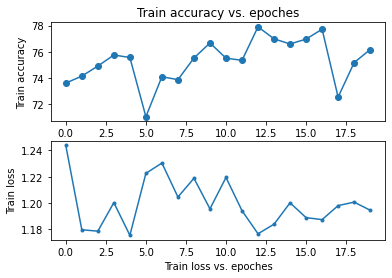

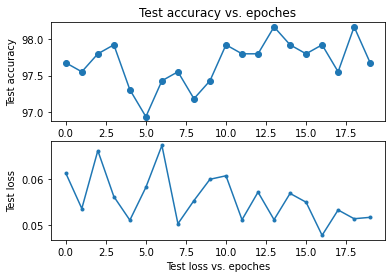

---------------Training_for_SAR-----------------


Epoch 0/19



Training Loss: 0.3755 Acc: 0.2156



acc for each class: tensor([0.0006, 0.0014, 0.0018, 0.0016, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0903 Acc: 0.7956
Time from Start 5m 20s

Epoch 1/19



Training Loss: 0.3760 Acc: 0.2147



acc for each class: tensor([0.0005, 0.0014, 0.0019, 0.0017, 0.0023, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0997 Acc: 0.7968
Time from Start 10m 44s

Epoch 2/19



Training Loss: 0.3739 Acc: 0.2163



acc for each class: tensor([0.0005, 0.0014, 0.0018, 0.0017, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0986 Acc: 0.7993
Time from Start 16m 7s

Epoch 3/19



Training Loss: 0.3746 Acc: 0.2230



acc for each class: tensor([0.0005, 0.0015, 0.0018, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1019 Acc: 0.7980

Epoch 4/19



Training Loss: 0.3751 Acc: 0.2199



acc for each class: tensor([0.0006, 0.0015, 0.0017, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0973 Acc: 0.7895

Epoch 5/19



Training Loss: 0.3722 Acc: 0.2218



acc for each class: tensor([0.0006, 0.0014, 0.0017, 0.0017, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0933 Acc: 0.8017
Time from Start 32m 11s

Epoch 6/19



Training Loss: 0.3702 Acc: 0.2143



acc for each class: tensor([0.0006, 0.0014, 0.0019, 0.0016, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0950 Acc: 0.8029
Time from Start 37m 20s

Epoch 7/19



Training Loss: 0.3718 Acc: 0.2282



acc for each class: tensor([0.0007, 0.0014, 0.0018, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0996 Acc: 0.7919

Epoch 8/19



Training Loss: 0.3680 Acc: 0.2207



acc for each class: tensor([0.0006, 0.0014, 0.0018, 0.0017, 0.0023, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.1025 Acc: 0.7968

Epoch 9/19



Training Loss: 0.3740 Acc: 0.2292



acc for each class: tensor([0.0006, 0.0013, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0023, 0.0024,
        0.0022])
Test Loss: 0.0965 Acc: 0.7919

Epoch 10/19



Training Loss: 0.3750 Acc: 0.2284



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0017, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0966 Acc: 0.7968

Epoch 11/19



Training Loss: 0.3714 Acc: 0.2245



acc for each class: tensor([0.0005, 0.0014, 0.0017, 0.0018, 0.0023, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0964 Acc: 0.7980

Epoch 12/19



Training Loss: 0.3736 Acc: 0.2263



acc for each class: tensor([0.0007, 0.0015, 0.0017, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0916 Acc: 0.8029

Epoch 13/19



Training Loss: 0.3728 Acc: 0.2282



acc for each class: tensor([0.0007, 0.0014, 0.0017, 0.0019, 0.0023, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0946 Acc: 0.8005

Epoch 14/19



Training Loss: 0.3721 Acc: 0.2266



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0968 Acc: 0.8127
Time from Start 80m 39s

Epoch 15/19



Training Loss: 0.3667 Acc: 0.2269



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0021])
Test Loss: 0.1007 Acc: 0.8029

Epoch 16/19



Training Loss: 0.3684 Acc: 0.2281



acc for each class: tensor([0.0006, 0.0014, 0.0017, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0973 Acc: 0.8054

Epoch 17/19



Training Loss: 0.3668 Acc: 0.2319



acc for each class: tensor([0.0006, 0.0015, 0.0017, 0.0017, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0918 Acc: 0.8017

Epoch 18/19



Training Loss: 0.3747 Acc: 0.2379



acc for each class: tensor([0.0006, 0.0015, 0.0017, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0921 Acc: 0.8115

Epoch 19/19



Training Loss: 0.3616 Acc: 0.2279



acc for each class: tensor([0.0005, 0.0014, 0.0018, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0906 Acc: 0.8017


Training complete in 107m 18s
Best train Acc: 0.237912
Best val Acc: 0.812729


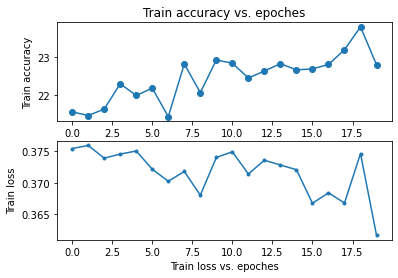

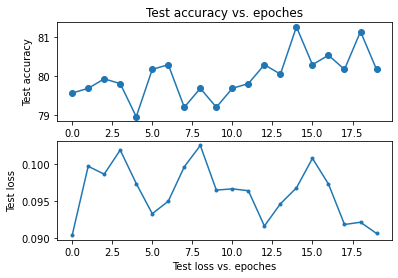

---------------Start KD iteration_3-----------------
---------------Training_for_EO-----------------


Epoch 0/19



Training Loss: 1.1999 Acc: 0.7824



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0536 Acc: 0.9816
Time from Start 3m 51s

Epoch 1/19



Training Loss: 1.1915 Acc: 0.7730



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0481 Acc: 0.9804

Epoch 2/19



Training Loss: 1.1817 Acc: 0.7708



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0511 Acc: 0.9792

Epoch 3/19



Training Loss: 1.2059 Acc: 0.7728



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0545 Acc: 0.9792

Epoch 4/19



Training Loss: 1.1700 Acc: 0.7648



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0498 Acc: 0.9780

Epoch 5/19



Training Loss: 1.1744 Acc: 0.7812



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0516 Acc: 0.9780

Epoch 6/19



Training Loss: 1.1908 Acc: 0.7636



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0501 Acc: 0.9804

Epoch 7/19



Training Loss: 1.1995 Acc: 0.7843



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0525 Acc: 0.9816

Epoch 8/19



Training Loss: 1.1973 Acc: 0.7706



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0549 Acc: 0.9792

Epoch 9/19



Training Loss: 1.1680 Acc: 0.7711



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0495 Acc: 0.9780

Epoch 10/19



Training Loss: 1.2228 Acc: 0.7651



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0524 Acc: 0.9804

Epoch 11/19



Training Loss: 1.1860 Acc: 0.7707



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0511 Acc: 0.9804

Epoch 12/19



Training Loss: 1.1489 Acc: 0.7727



acc for each class: tensor([0.0024, 0.0021, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0521 Acc: 0.9792

Epoch 13/19



Training Loss: 1.1506 Acc: 0.7684



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0461 Acc: 0.9804

Epoch 14/19



Training Loss: 1.1836 Acc: 0.7852



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0547 Acc: 0.9792

Epoch 15/19



Training Loss: 1.1459 Acc: 0.7636



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0505 Acc: 0.9780

Epoch 16/19



Training Loss: 1.1723 Acc: 0.7735



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0471 Acc: 0.9792

Epoch 17/19



Training Loss: 1.1722 Acc: 0.7801



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0505 Acc: 0.9816

Epoch 18/19



Training Loss: 1.1805 Acc: 0.7670



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0528 Acc: 0.9804

Epoch 19/19



Training Loss: 1.1636 Acc: 0.7896



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0483 Acc: 0.9804


Training complete in 105m 44s
Best train Acc: 0.789628
Best val Acc: 0.981640


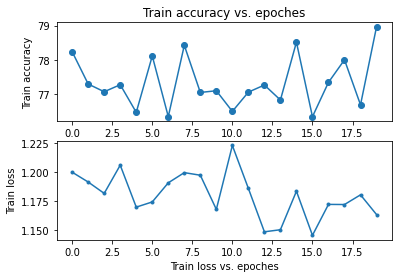

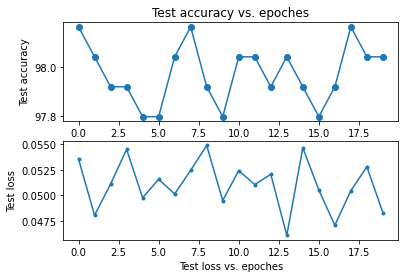

---------------Training_for_SAR-----------------


Epoch 0/19



Training Loss: 0.3675 Acc: 0.2243



acc for each class: tensor([0.0007, 0.0016, 0.0018, 0.0018, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0980 Acc: 0.8091
Time from Start 8m 10s

Epoch 1/19



Training Loss: 0.3709 Acc: 0.2323



acc for each class: tensor([0.0009, 0.0015, 0.0019, 0.0017, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0933 Acc: 0.8250
Time from Start 16m 16s

Epoch 2/19



Training Loss: 0.3637 Acc: 0.2354



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0933 Acc: 0.8078

Epoch 3/19



Training Loss: 0.3680 Acc: 0.2352



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0959 Acc: 0.8029

Epoch 4/19



Training Loss: 0.3738 Acc: 0.2388



acc for each class: tensor([0.0007, 0.0017, 0.0018, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0947 Acc: 0.8091

Epoch 5/19



Training Loss: 0.3707 Acc: 0.2334



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0905 Acc: 0.8029

Epoch 6/19



Training Loss: 0.3649 Acc: 0.2328



acc for each class: tensor([0.0006, 0.0016, 0.0017, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0913 Acc: 0.7968

Epoch 7/19



Training Loss: 0.3684 Acc: 0.2407



acc for each class: tensor([0.0008, 0.0015, 0.0018, 0.0016, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0890 Acc: 0.8078

Epoch 8/19



Training Loss: 0.3694 Acc: 0.2406



acc for each class: tensor([0.0005, 0.0014, 0.0017, 0.0016, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0886 Acc: 0.8042

Epoch 9/19



Training Loss: 0.3734 Acc: 0.2457



acc for each class: tensor([0.0006, 0.0014, 0.0018, 0.0016, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0904 Acc: 0.8005

Epoch 10/19



Training Loss: 0.3673 Acc: 0.2340



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0018, 0.0024, 0.0021, 0.0024, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0879 Acc: 0.8066

Epoch 11/19



Training Loss: 0.3669 Acc: 0.2331



acc for each class: tensor([0.0006, 0.0014, 0.0018, 0.0018, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0877 Acc: 0.8091

Epoch 12/19



Training Loss: 0.3672 Acc: 0.2270



acc for each class: tensor([0.0006, 0.0016, 0.0019, 0.0017, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0885 Acc: 0.8091

Epoch 13/19



Training Loss: 0.3696 Acc: 0.2428



acc for each class: tensor([0.0007, 0.0015, 0.0017, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0965 Acc: 0.8091

Epoch 14/19



Training Loss: 0.3730 Acc: 0.2546



acc for each class: tensor([0.0006, 0.0015, 0.0019, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0884 Acc: 0.8140

Epoch 15/19



Training Loss: 0.3663 Acc: 0.2394



acc for each class: tensor([0.0006, 0.0016, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0825 Acc: 0.8152

Epoch 16/19



Training Loss: 0.3684 Acc: 0.2379



acc for each class: tensor([0.0005, 0.0015, 0.0020, 0.0017, 0.0024, 0.0022, 0.0023, 0.0023, 0.0024,
        0.0022])
Test Loss: 0.0968 Acc: 0.8091

Epoch 17/19



Training Loss: 0.3692 Acc: 0.2399



acc for each class: tensor([0.0005, 0.0016, 0.0018, 0.0019, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0895 Acc: 0.8127

Epoch 18/19



Training Loss: 0.3708 Acc: 0.2429



acc for each class: tensor([0.0005, 0.0016, 0.0019, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0937 Acc: 0.8176

Epoch 19/19



Training Loss: 0.3728 Acc: 0.2387



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0921 Acc: 0.8127


Training complete in 163m 0s
Best train Acc: 0.254618
Best val Acc: 0.824969


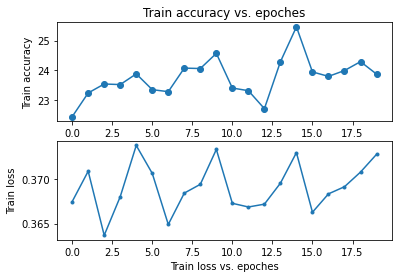

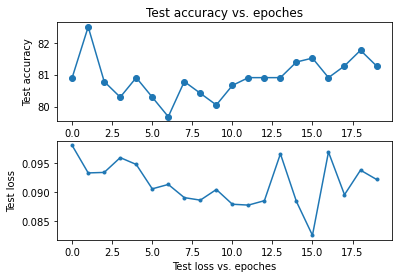

---------------Start KD iteration_4-----------------
---------------Training_for_EO-----------------


Epoch 0/19



Training Loss: 1.1722 Acc: 0.7794



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0497 Acc: 0.9804
Time from Start 5m 42s

Epoch 1/19



Training Loss: 1.1547 Acc: 0.7765



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0510 Acc: 0.9792

Epoch 2/19



Training Loss: 1.1930 Acc: 0.7872



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0512 Acc: 0.9792

Epoch 3/19



Training Loss: 1.1458 Acc: 0.7622



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0505 Acc: 0.9804

Epoch 4/19



Training Loss: 1.1589 Acc: 0.7821



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0501 Acc: 0.9804

Epoch 5/19



Training Loss: 1.1736 Acc: 0.7790



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0502 Acc: 0.9816
Time from Start 34m 41s

Epoch 6/19



Training Loss: 1.2059 Acc: 0.7652



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0526 Acc: 0.9804

Epoch 7/19



Training Loss: 1.1776 Acc: 0.7772



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0517 Acc: 0.9816

Epoch 8/19



Training Loss: 1.1576 Acc: 0.7716



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0495 Acc: 0.9804

Epoch 9/19



Training Loss: 1.1657 Acc: 0.7844



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0022, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0537 Acc: 0.9816

Epoch 10/19



Training Loss: 1.1720 Acc: 0.7802



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0515 Acc: 0.9816

Epoch 11/19



Training Loss: 1.1936 Acc: 0.7792



acc for each class: tensor([0.0024, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0535 Acc: 0.9804

Epoch 12/19



Training Loss: 1.1422 Acc: 0.7775



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0502 Acc: 0.9816

Epoch 13/19



Training Loss: 1.1860 Acc: 0.7670



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0505 Acc: 0.9816

Epoch 14/19



Training Loss: 1.1925 Acc: 0.7745



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0544 Acc: 0.9816

Epoch 15/19



Training Loss: 1.1692 Acc: 0.7758



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0496 Acc: 0.9804

Epoch 16/19



Training Loss: 1.1890 Acc: 0.7769



acc for each class: tensor([0.0023, 0.0023, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0574 Acc: 0.9792

Epoch 17/19



Training Loss: 1.1728 Acc: 0.7632



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0517 Acc: 0.9780

Epoch 18/19



Training Loss: 1.2038 Acc: 0.7667



acc for each class: tensor([0.0023, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0524 Acc: 0.9780

Epoch 19/19



Training Loss: 1.1800 Acc: 0.7765



acc for each class: tensor([0.0024, 0.0022, 0.0024, 0.0024, 0.0024, 0.0023, 0.0024, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0564 Acc: 0.9792


Training complete in 116m 11s
Best train Acc: 0.787174
Best val Acc: 0.981640


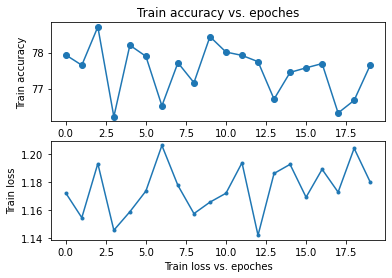

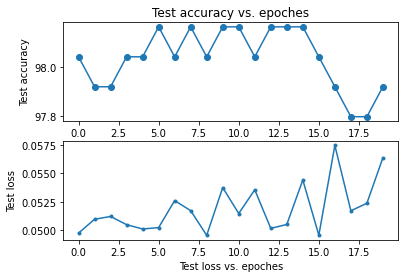

---------------Training_for_SAR-----------------


Epoch 0/19



Training Loss: 0.3738 Acc: 0.2430



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0947 Acc: 0.8127
Time from Start 8m 11s

Epoch 1/19



Training Loss: 0.3666 Acc: 0.2362



acc for each class: tensor([0.0006, 0.0015, 0.0019, 0.0018, 0.0023, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0901 Acc: 0.8127

Epoch 2/19



Training Loss: 0.3651 Acc: 0.2331



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0895 Acc: 0.8078

Epoch 3/19



Training Loss: 0.3722 Acc: 0.2375



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0909 Acc: 0.8078

Epoch 4/19



Training Loss: 0.3684 Acc: 0.2343



acc for each class: tensor([0.0007, 0.0014, 0.0017, 0.0017, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0891 Acc: 0.8066

Epoch 5/19



Training Loss: 0.3707 Acc: 0.2314



acc for each class: tensor([0.0008, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0901 Acc: 0.8091

Epoch 6/19



Training Loss: 0.3706 Acc: 0.2320



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0901 Acc: 0.8127

Epoch 7/19



Training Loss: 0.3716 Acc: 0.2335



acc for each class: tensor([0.0007, 0.0016, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0879 Acc: 0.8152
Time from Start 65m 34s

Epoch 8/19



Training Loss: 0.3699 Acc: 0.2335



acc for each class: tensor([0.0006, 0.0015, 0.0018, 0.0018, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0887 Acc: 0.8103

Epoch 9/19



Training Loss: 0.3673 Acc: 0.2344



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0022])
Test Loss: 0.0864 Acc: 0.8115

Epoch 10/19



Training Loss: 0.3658 Acc: 0.2352



acc for each class: tensor([0.0008, 0.0016, 0.0018, 0.0018, 0.0024, 0.0020, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0858 Acc: 0.8176
Time from Start 90m 4s

Epoch 11/19



Training Loss: 0.3666 Acc: 0.2350



acc for each class: tensor([0.0007, 0.0015, 0.0018, 0.0017, 0.0024, 0.0021, 0.0022, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0887 Acc: 0.8152

Epoch 12/19



Training Loss: 0.3692 Acc: 0.2349



acc for each class: tensor([0.0007, 0.0015, 0.0017, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0886 Acc: 0.8127

Epoch 13/19



Training Loss: 0.3655 Acc: 0.2376



acc for each class: tensor([0.0008, 0.0015, 0.0018, 0.0018, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0888 Acc: 0.8164

Epoch 14/19



Training Loss: 0.3682 Acc: 0.2400



acc for each class: tensor([0.0007, 0.0016, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0896 Acc: 0.8140

Epoch 15/19



Training Loss: 0.3680 Acc: 0.2396



acc for each class: tensor([0.0007, 0.0014, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0888 Acc: 0.8152

Epoch 16/19



Training Loss: 0.3616 Acc: 0.2372



acc for each class: tensor([0.0008, 0.0014, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0871 Acc: 0.8127

Epoch 17/19



Training Loss: 0.3682 Acc: 0.2391



acc for each class: tensor([0.0007, 0.0015, 0.0017, 0.0019, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0886 Acc: 0.8140

Epoch 18/19



Training Loss: 0.3686 Acc: 0.2391



acc for each class: tensor([0.0008, 0.0014, 0.0017, 0.0017, 0.0024, 0.0022, 0.0023, 0.0024, 0.0024,
        0.0023])
Test Loss: 0.0867 Acc: 0.8127

Epoch 19/19



Training Loss: 0.3737 Acc: 0.2458



acc for each class: tensor([0.0008, 0.0014, 0.0018, 0.0017, 0.0024, 0.0021, 0.0023, 0.0024, 0.0024,
        0.0024])
Test Loss: 0.0881 Acc: 0.8176


Training complete in 163m 24s
Best train Acc: 0.245790
Best val Acc: 0.817625


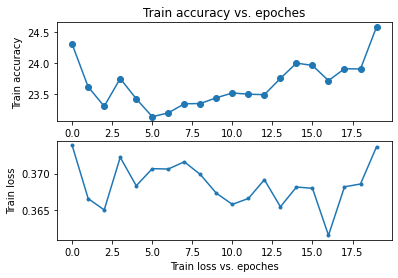

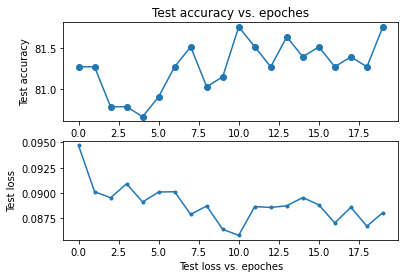

<Figure size 432x288 with 0 Axes>

In [30]:
iter_num = 0
iter_numer = 5
iter_train()

## Prediction

In [50]:
model = torch.load("50_basic_iteration/EOiter4_resnet34_kd_best.pt")

import pandas as pd
from torch.utils import data
from tqdm import tqdm
from PIL import Image
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)#.convert('RGB')
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)

    
BATCH_SIZE = 1
test_dir = "data/NTIRE2021_Class_valid_images_EO"
test_dir_ls = os.listdir(test_dir)
test_dir_ls.sort()
test_df = pd.DataFrame(test_dir_ls)

test_dataset = ImageData(test_df,test_dir,EO_data_transforms["valid_EO"],test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

output_dim = 10

DISABLE_TQDM = False
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = model(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1
    


100%|██████████| 770/770 [00:20<00:00, 37.11it/s]


In [51]:
predictions[170]

array([ 0.49862829,  0.69811857, -0.25124538, -0.11835846, -0.11030938,
       -0.13866964, -0.20759502, -0.00445211, -0.14589342, -0.1689586 ])

In [52]:
pred = np.argmax(predictions,axis = 1)
pred_list = []
for i in range(len(pred)):
    result = [pred[i]]
    pred_list.append(result)
pred_list



[[0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [0],
 [0],
 [1],
 [7],
 [0],
 [0],
 [0],
 [0],
 [0],
 [3],
 [0],
 [0],
 [0],
 [0],
 [7],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [3],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [3],
 [0],
 [2],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [0],
 [8],
 [0],
 [3],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [7],
 [7],
 [0],
 [7],
 [0],
 [7],
 [0],
 [7],
 [0],
 [7],
 [1],
 [7],
 [1],
 [0],
 [7],
 [3],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [7],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [3],
 [0],
 [1],
 [7],
 [7],
 [7],
 [0],
 [1],
 [7],
 [7],
 [7],
 [0],
 [7],
 [7],
 [7],
 [7],
 [0],
 [1],
 [0],
 [1],
 [0],
 [7],
 [7],
 [7]

In [57]:
predicted_class_idx = pred_list

test_df['class_id'] = predicted_class_idx
test_df['class_id'] = test_df['class_id'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'image_id'})
test_df['image_id'] = test_df['image_id'].apply(lambda x : x.split('.')[0])
test_df


,image_id,class_id
0,101250,0
1,102512,0
2,102724,1
3,103079,0
4,103232,0
...,...,...
765,93121,0
766,93871,0
767,94333,0
768,94927,0


In [58]:
for (idx, row) in test_df.iterrows():
    row.image_id = row.image_id.split("_")[1]


IndexError: list index out of range

In [66]:
i = 0
for (idx, row) in test_df.iterrows():
    if row.class_id != "0":
        i+=1
print(i)

235


In [67]:
test_df

,image_id,class_id
0,101250,0
1,102512,0
2,102724,1
3,103079,0
4,103232,0
...,...,...
765,93121,0
766,93871,0
767,94333,0
768,94927,0


In [68]:
test_df.to_csv('50_basic_iteration/results.csv',index = False)